In [1]:
import xarray as xr
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from tqdm.notebook import tqdm

from isca_tools.cesm import get_pressure
from isca_tools.convection.base import lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, \
    get_scale_factor_theory, get_sensitivity_factors
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc, isel_float
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
leg_handlelength = 1.5

## Load data and average over `lon_sample` dimension
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [8]:
%%time
p_ft_use = 400 * 100
ds = {}
with tqdm(total=2, position=0, leave=True) as pbar:
    for surf in ['ocean', 'land']:
        ds[surf] = xr.load_dataset(os.path.join(utils.out_dir, f"ds_tropics_{surf}.nc")).sel(p_ft=p_ft_use)
        ds[surf]['p_lnb_approx'] = get_pressure(ds[surf].PS, ds[surf].P0, ds[surf].hyam, ds[surf].hybm).isel(
            lev=ds[surf].lnb1_ind)

        # Chose best rh_mod
        for key2 in ['mod_parcel', 'const']:
            ds[surf][f'{key2}_rh_mod_ind'] = ds[surf][f'{key2}_error'].sum(dim='layer').argmin(dim='rh_mod')
            for key3 in ['lapse', 'integral', 'error']:
                ds[surf][f'{key2}_{key3}'] = ds[surf][f'{key2}_{key3}'].isel(rh_mod=ds[surf][f'{key2}_rh_mod_ind'])
        # Record actual rh_mod value
        ds[surf]['mod_parcel_rh_mod'] =  ds[surf].rh_mod[ds[surf].mod_parcel_rh_mod_ind]

        ds[surf]['lapse_Dz'] = ds[surf].mod_parcel_lapse.isel(layer=0) / 1000 - lapse_dry
        ds[surf]['lapse_Mz'] = ds[surf].mod_parcel_lapse.isel(layer=1) / 1000
        ds[surf]['lapse_D'] = R / g * ds[surf].TREFHT * ds[surf]['lapse_Dz']
        ds[surf]['lapse_M'] = R / g * ds[surf].T_ft_env * ds[surf]['lapse_Mz']

        pbar.update(1)


lat_weights = utils.lat_weights.reindex_like(ds[surf].lat)
temp_surf_lcl_calc = ds['ocean'].temp_surf_lcl_calc
p_ft = float(ds['ocean'].p_ft)



CPU times: user 52.8 s, sys: 11.7 s, total: 1min 4s
Wall time: 1min 9s


In [53]:
def get_ds_quant_and_ref(ds):
    mask_fit = utils.get_valid_mask(ds)

    # Get rid of variables don't need anymore - those with layer dimension
    ds = ds.drop_dims(['layer', 'lev'])

    # ds_ref = ds.where(mask_fit).mean(dim=['sample', 'quant'])  # reference average over all convective days
    # Reference is computed from all days
    ds_ref = ds.mean(dim=['lon_sample', 'quant'])  # reference average over all days, even not convective
    # For each quantile, only consider those days for which are convective. As cannot say anything about non-convective days in modParc framework
    ds_quant = ds.where(mask_fit).mean(dim='lon_sample')
    ds_quant['n_conv_days'] = mask_fit.sum(dim='lon_sample')

    # Add standard deviation for lapse rate variables
    ds_quant_std = ds[['lapse_D', 'lapse_M', 'mod_parcel_rh_mod']].where(mask_fit).std(dim='lon_sample')
    for key in ds_quant_std:
        ds_quant[f"{key}_std"] = ds_quant_std[key]
    return ds_quant, ds_ref, mask_fit
    # ds_ref = ds_quant.mean(dim='quant')  # reference, treat each quant the same so av TREFHT actuall


ds_quant = [0, 0]
ds_ref = [0, 0]
mask_conv_valid = [0, 0]
for i, surf in enumerate(ds):
    ds_quant[i], ds_ref[i], mask_conv_valid[i] = get_ds_quant_and_ref(ds[surf])
ds_quant = xr.concat(ds_quant, dim=xr.DataArray(list(ds.keys()), dims="surf", name='surf'))
ds_ref = xr.concat(ds_ref, dim=xr.DataArray(list(ds.keys()), dims="surf", name='surf'))
mask_conv_valid = xr.concat(mask_conv_valid, dim=xr.DataArray(list(ds.keys()), dims="surf", name='surf'))

# Remove rh_mod dimension, and rename variable as rh_mod
ds_quant = ds_quant.drop_vars('rh_mod')
ds_ref = ds_ref.drop_vars('rh_mod')
ds_quant = ds_quant.rename_vars({'mod_parcel_rh_mod': 'rh_mod', 'mod_parcel_rh_mod_std': 'rh_mod_std'})
ds_ref = ds_ref.rename_vars({'mod_parcel_rh_mod': 'rh_mod'})

In [54]:
# Set RH and Pressure reference values to their colder state value
ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(co2=0)
ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(co2=0)

# Ref lapse params are 0 as parcel
ds_ref['lapse_Dz'] = ds_ref['lapse_Dz'] * 0
ds_ref['lapse_Mz'] = ds_ref['lapse_Mz'] * 0
ds_ref['lapse_D'] = ds_ref['lapse_D'] * 0
ds_ref['lapse_M'] = ds_ref['lapse_M'] * 0
ds_ref['rh_mod'] = ds_ref['rh_mod'] * 0

# Set reference FT temperature to that following a parcel profile
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT+ds_ref.rh_mod, ds_ref.PREFHT,
                                    p_ft, 0, 0, ds_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})


ds_quant = ds_quant.transpose('surf', 'co2', 'quant', 'lat')
ds_ref = ds_ref.transpose('surf', 'co2', 'lat')

## Scaling factor
I first get the scaling factor both numerically and normal linear theory, making the function work with xarray.

In [25]:
%%time
ds_sf = utils.apply_sf_theory_with_rh_mod(ds_quant, ds_ref, p_ft, temp_surf_lcl_calc,
                                          numerical=False)
ds_sf_num = utils.apply_sf_theory_with_rh_mod(ds_quant, ds_ref, p_ft, temp_surf_lcl_calc, numerical=True)

CPU times: user 2min 18s, sys: 891 ms, total: 2min 19s
Wall time: 2min 20s


In [26]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_num["nl_sum"] = ds_sf_num['scale_factor_nl'] - ds_sf_num['scale_factor_linear'] + 1
# Set numerical method to show difference to linear theory
for key in ds_sf:
    if 'scale_factor_sum' in key:
        continue
    if 'rh_mod' in key:
        continue
    if 'rh' in key:
        # combine physical and mod linear contributions as done in numerical
        var = ds_sf[key] + ds_sf[key.replace('rh', 'rh_mod')] - 1
    else:
        var = ds_sf[key]
    ds_sf_num[key] = ds_sf_num[key] - var + 1

### Theoretical scaling factor
Below I plot the theoretical scaling factor in modParc framework.

Weighting is slightly different in that not same amount of convective days at each latitude for each quant. So for each quant, preferentially weight latitudes with more convective days.

In [42]:
style_map = utils.style_map_cont
style_map["nl_rh_anom_lapse_M_change"] =  ('C2', '-', '$\Delta r_s \delta \eta_M$')

In [43]:
# Ensure when averaging over latitude for each quant, that weight the more convective latitudes more
weights_use = ds_quant.n_conv_days.sum(dim='co2')
weights_use = weights_use * lat_weights  # combine with lat weights
# set max to 1 for interpretation i.e. if weight=1 that lat contributes most for that quant
weights_use = weights_use / weights_use.max(dim='lat')

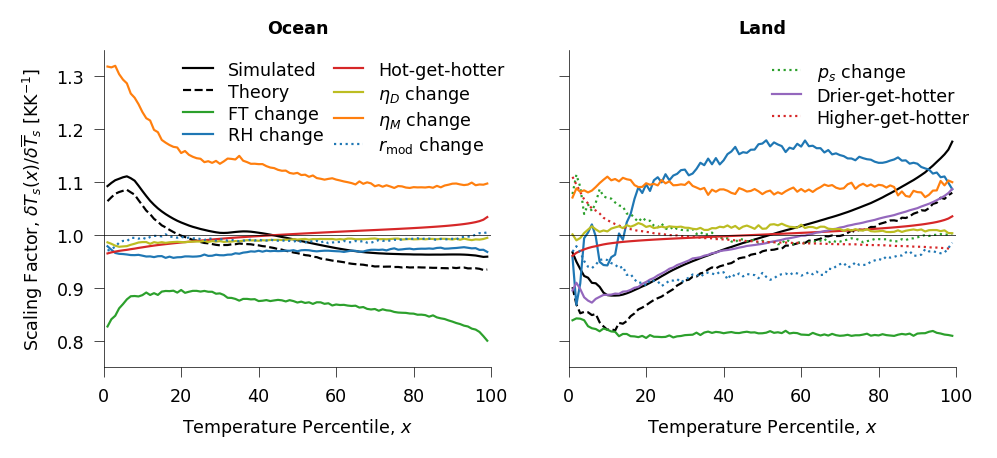

In [44]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
keys_added = []
for k in range(ds_sf.surf.size):
    ax[k].set_title(ds_sf.surf.values[k].capitalize(), fontweight='bold')
    for key in ['', '_sum']:
        var = ds_sf.isel(surf=k)[f"scale_factor{key}"].weighted(weights_use.isel(surf=k)).mean(dim='lat')
        #var = np.average(ds_sf.isel(surf=k)[f"scale_factor{key}"], axis=0, weights=lat_weights)
        ax[k].plot(ds_sf.quant, var,
                   color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
                   label=style_map[f"scale_factor{key}"][2] if k == 0 else None)
    # ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape[f"scale_factor_sum"], axis=0, weights=lat_weights),
    #         color=style_map[f"scale_factor_sum"][0],
    #         label='Theory (CAPE)', linestyle=':')
    # ax.plot(ds_sf_num.quant,
    #         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
    #         color='k', linestyle='--', label='Linear + nl_r_change')
    for key in ds_sf:
        if 'scale_factor' in key:
            continue
        if np.nanmax(np.average(np.abs(ds_sf.isel(surf=k)[key] - 1), axis=0, weights=lat_weights)) < 0.02:
            continue
        var = ds_sf.isel(surf=k)[key].weighted(ds_quant.isel(surf=k).n_conv_days.sum(dim='co2')).mean(dim='lat')
        # var = np.average(ds_sf.isel(surf=k)[key], axis=0, weights=lat_weights)
        ax[k].plot(ds_sf.quant, var,
                   label=None if key in keys_added else style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])
        keys_added.append(key)
    # # sanity check that all other mechanisms are the same
    # if 'lapse' in key:
    #     continue
    # ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape[key], axis=0, weights=lat_weights), color=style_map[key][0],
    #            linestyle=':')
# ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape['sCAPE_change'], axis=0, weights=lat_weights),
#         color=style_map['sCAPE_change'][0], linestyle=':', label='CAPE change')

update_linewidth(fig)
ax[0].legend(ncol=2, handlelength=leg_handlelength, labelspacing=0.2, columnspacing=0.5, bbox_to_anchor=(1.08, 1.02),
             loc='upper right')

ax[1].legend(handlelength=leg_handlelength, labelspacing=0.2, bbox_to_anchor=(1.08, 1.02), loc='upper right')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlabel(utils.percentile_label)
ax[1].set_xlabel(utils.percentile_label)
ax[0].set_ylabel(utils.sf_label)
update_fontsize(fig)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0.75, 1.35)
plt.show()
# savefig(fig)

### Deviation from simulated and theoretical estimates
Why do the simulated and theoretical scaling factors differ?
Below, we split it up into neglecting terms in sum of individual mechanisms, and neglecting non-linear combination of mechanisms.

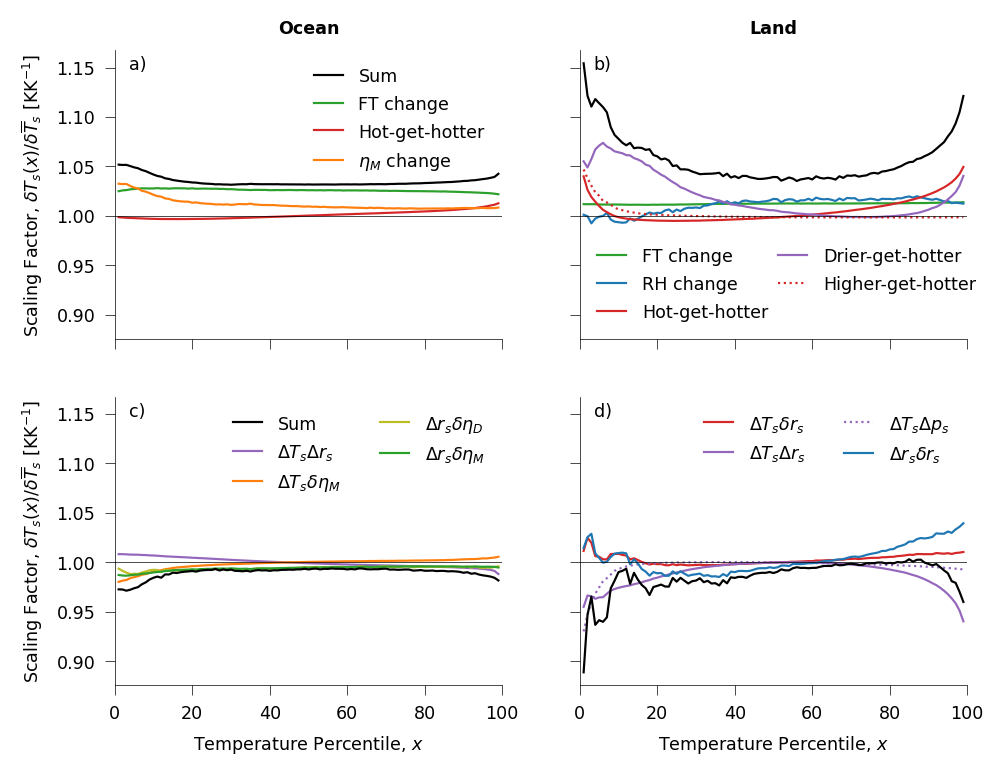

In [48]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
for k in range(ds_sf.surf.size):
    ax[0, k].set_title(ds_sf.surf.values[k].capitalize(), fontweight='bold')
    ax[1, k].set_xlabel(utils.percentile_label)
    # ax[0].set_title('Individual Mechanism Error', fontweight='bold')
    #ax[1].set_title('Mechanism Combination Error', fontweight='bold')
    ax[0, k].plot(ds_sf_num.quant,
                  (ds_sf_num['scale_factor_linear'] - ds_sf['scale_factor_sum'] + 1).isel(surf=k).weighted(
                      weights_use.isel(surf=k)).mean(dim='lat'),
                  color='k', label='Sum' if k == 0 else None)

    ax[1, k].plot(ds_sf_num.quant, ds_sf_num['nl_sum'].isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat'),
                  color='k', linestyle='-', label='Sum' if k == 0 else None, zorder=20)

    # Plot individual mechanism error
    for key in ds_sf:
        if 'scale_factor' in key:
            continue
        if 'rh_mod' in key:
            continue
        if np.nanmax(np.abs(ds_sf[key] - 1).isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat')) < 0.01:
            continue
        if np.nanmax(np.abs(ds_sf_num[key] - 1).isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat')) > 0.01:
            ax[0, k].plot(ds_sf.quant, ds_sf_num[key].isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat'),
                          label=style_map[key][2], color=style_map[key][0], linestyle=style_map[key][1])

    # Plot combination of mechanism error
    for key in ds_sf_num:
        if ('nl' not in key) or ('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('residual' in key):
            continue
        # Just plot 4 strongest mechanisms
        thresh = [0.01, 0.03]
        if np.nanmax(np.abs(ds_sf_num[key] - 1).isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat')) > thresh[k]:
            ax[1, k].plot(ds_sf.quant, ds_sf_num[key].isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat'),
                          label=style_map[key][2],
                          color=style_map[key][0], linestyle=style_map[key][1])
#
update_linewidth(fig)
ax[0, 0].legend(handlelength=leg_handlelength, loc='upper right')
ax[1, 0].legend(ncol=2, handlelength=leg_handlelength)
ax[0, 1].legend(ncol=2, handlelength=leg_handlelength, columnspacing=0.5)
ax[1, 1].legend(ncol=2, handlelength=leg_handlelength)
label_subplots(fig, ax.flatten(), pos_y=-2)
for ax_use in ax.flatten():
    ax_use.axhline(1, color='k', lw=ax_linewidth)
ax[0, 0].set_ylabel(utils.sf_label)
ax[1, 0].set_ylabel(utils.sf_label)
update_fontsize(fig)
ax[0, 0].set_xlim(0, 100)
# ax[0, 0].set_ylim(0.75, 1.35)
plt.show()
# savefig(fig)

## Lapse rate values
Show values of the lapse rate parameters, and also include daily max data for comparison, and to comment about dry lapse rate.

Weighting is slightly different in that now in top row, we are plotting a value from a single climate hence use weighting from single climate `weights_use_sc`.

In [49]:
# For single climate, just use co2=0. weights_use was for scaling factor so combines co2 datasets
weights_use_sc = ds_quant.n_conv_days.isel(co2=0)
weights_use_sc = weights_use_sc * lat_weights  # combine with lat weights
# set max to 1 for interpretation i.e. if weight=1 that lat contributes most for that quant
weights_use_sc = weights_use_sc / weights_use_sc.max(dim='lat')

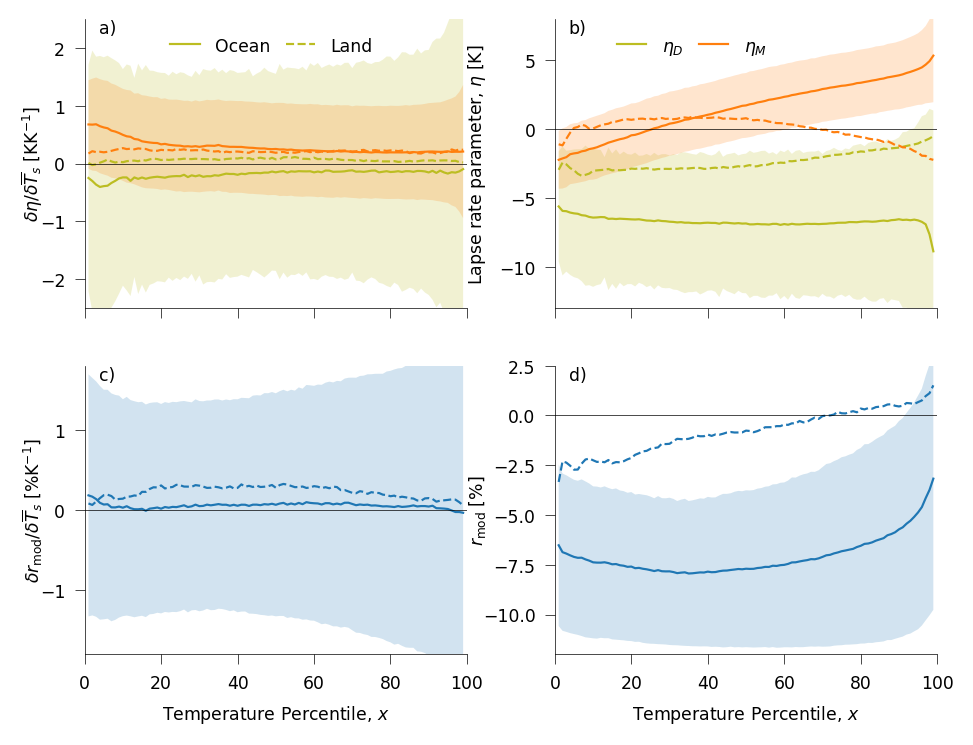

In [119]:
 #%%capture cap
linestyle_surf = [None, '--']
fig, ax = plt.subplots(2, 2, sharex=True)
fig_resize(fig, width['two_col'])
ax_use = {'lapse_D': [ax[0, 1], ax[0, 0]], 'lapse_M': [ax[0, 1], ax[0, 0]], 'rh_mod': [ax[1, 1], ax[1, 0]]}
for i, key in enumerate(['lapse_D', 'lapse_M', 'rh_mod']):
    for j in range(ds_sf.surf.size):
        var = ds_quant[key].isel(co2=0).isel(surf=j)
        var_std = ds_quant[f"{key}_std"].isel(co2=0).isel(surf=j)
        if 'rh_mod' in key:
            # convert to %
            var = var * 100
            var_std = var_std * 100
        ax_use[key][0].plot(ds_sf.quant, var.weighted(weights_use_sc.isel(surf=j)).mean(dim='lat'),
                            color=utils.style_map_cont[f"{key}_change"][0], linestyle=linestyle_surf[j],
                            label=['$\eta_D$', '$\eta_M$', '$r_{\\text{mod}}$'][i] if j==0 else None)
        if j == 0:
            ax_use[key][0].fill_between(ds_sf.quant,
                                        (var - var_std).weighted(weights_use_sc.isel(surf=j)).mean(dim='lat'),
                                        (var + var_std).weighted(weights_use_sc.isel(surf=j)).mean(dim='lat'),
                                        alpha=0.2,
                                        color=utils.style_map_cont[f'{key}_change'][0], edgecolor="none")
        var = (ds_quant[key].diff(dim='co2').squeeze() /
               ds_ref.isel(surf=j).TREFHT.diff(dim='co2').squeeze()).isel(surf=j)

        std_diff = np.sqrt(ds_quant[f"{key}_std"].isel(co2=0, surf=j) ** 2 +
                           ds_quant[f"{key}_std"].isel(co2=1, surf=j) ** 2
                           ) / ds_ref.isel(surf=j).TREFHT.diff(dim='co2').squeeze()
        if 'rh_mod' in key:
            var = var * 100
            std_diff = std_diff * 100
        ax_use[key][1].plot(ds_sf.quant, var.weighted(weights_use.isel(surf=j)).mean(dim='lat'),
                            color=utils.style_map_cont[f'{key}_change'][0], linestyle=linestyle_surf[j],
                            label=str(ds_quant.surf.values[j]).capitalize() if i == 0 else None)
        if j == 0:
            ax_use[key][1].fill_between(ds_sf.quant,
                                        (var - std_diff).weighted(weights_use.isel(surf=j)).mean(dim='lat'),
                                        (var + std_diff).weighted(weights_use.isel(surf=j)).mean(dim='lat'),
                                        alpha=0.2,
                                        color=utils.style_map_cont[f'{key}_change'][0], edgecolor="none")
update_linewidth(fig,1)
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
# ax[1].axhline(0, color='k', lw=ax_linewidth)


# handles, labels = ax[0, 0].get_legend_handles_labels()
# from matplotlib.lines import Line2D
# dummy = Line2D([], [], linestyle='None', marker=None, alpha=0)  # invisible handle
# # Put dummy as 2nd item so column 2 row 1 is empty:
# handles2 = [handles[0], handles[1], dummy, handles[2]]
# labels2  = [labels[0], labels[1], "", labels[2]]
ax[0, 0].legend(handlelength=leg_handlelength, ncol=2, loc='upper right',
                bbox_to_anchor=(1-0.2, 1), columnspacing=0.8)


ax[0, 1].legend(handlelength=leg_handlelength, loc='upper right',
                bbox_to_anchor=(1-0.4, 1), ncol=3, columnspacing=0.8)

label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=0)
ax[1, 0].set_xlabel(utils.percentile_label)
ax[1, 1].set_xlabel(utils.percentile_label)
ax[0, 1].set_ylabel('Lapse rate parameter, $\eta$ [K]')
ax[0, 0].set_ylabel('$\delta \eta/ \delta \overline{T}_s$ [KK$^{-1}$]', labelpad=-2)
ax[1, 1].set_ylabel('$r_{\\text{mod}}$ [%]', labelpad=-2)
ax[1, 0].set_ylabel('$\delta r_{\\text{mod}}/ \delta \overline{T}_s$ [%K$^{-1}$]', labelpad=-2)

ax[0, 0].set_xlim(0, 100)
ax[0, 0].set_ylim(-2.5, 2.5)
ax[0, 1].set_ylim(-13, 8)
ax[1, 0].set_ylim(-1.8, 1.8)
ax[1, 1].set_ylim(-12, 2.5)
fig.subplots_adjust(wspace=0.23)
update_fontsize(fig)
plt.show()
# savefig(fig)

## LNB Analysis
Idea is to show that cold day amplified warming is due to more days having LNB further from surface than 500hPa

The LNB and Miyawaki 2022 plots do not coincide - maybe no regime change.

The $\eta_M$ change mechanism and change in number of days LNB further from surface than FT level seem well correlated again. With warming, convection reaching higher in atmosphere.

Can also comment on using 700hPa instead of 500hPa - say error a lot higher, and see similar change in % of days p_LNB<p_ft when using p_ft=700hPa

NOTE - This is the % of convective days which satisfy a condition.

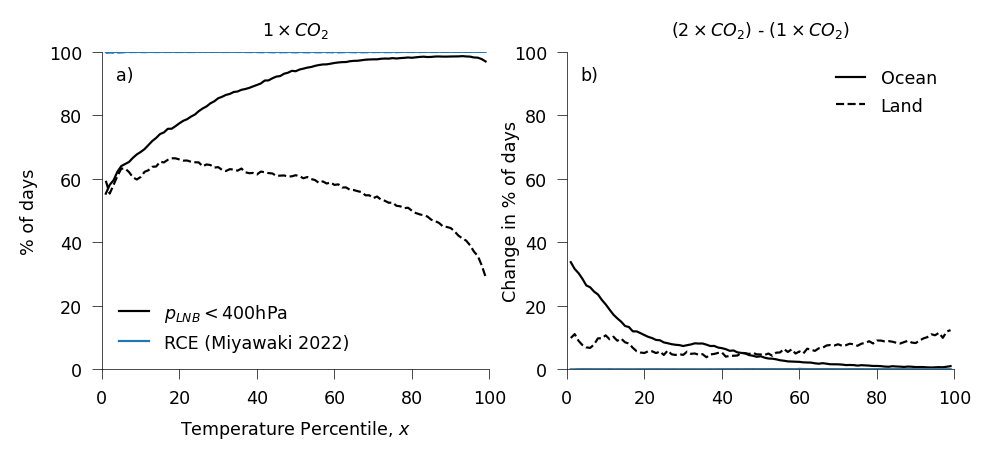

In [122]:
lapse_miy2022_M_thresh = 13  # 13% threshold value for RCE comes from paper
lnb_buoyancy_method = 'lcl'     # think lcl is better - better estimate of height convection can possibly reach
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False)
fig_resize(fig, width['two_col'])
# surf = 'ocean'
# n_sample = (ds[surf].TREFHT > 0).sum(dim='lon_sample')
for k, surf in enumerate(mask_conv_valid.surf.values.tolist()):
    # for i in range(ds.tau_lw.size):
    #     # ax[0].plot(ds_sf.quant, np.average(ds_quant['p_lnb_approx'].isel(tau_lw=i), axis=1, weights=lat_weights), color=f"C{i}")
    # var = (ds[surf][key] < p_ft).sum(dim='lon_sample') / n_sample
    n_sample = mask_conv_valid.isel(surf=k).sum(dim='lon_sample')       # total number of convective days at each location
    var = (ds[surf].p_lnb_approx.where(mask_conv_valid.isel(surf=k)) < p_ft).sum(dim='lon_sample') / n_sample
    ax[0].plot(ds[surf].quant, var.isel(co2=0).weighted(weights_use_sc.isel(surf=k)).mean(dim='lat') * 100, color=f"k",
               linestyle=[None, '--'][k], label='$p_{LNB} < ' + f'{p_ft / 100:.0f}$hPa' if k==0 else None)
    ax[1].plot(ds[surf].quant, var.diff(dim='co2').squeeze().weighted(weights_use.isel(surf=k)).mean(dim='lat') * 100, color=f"k",
               linestyle=[None, '--'][k], label=surf.capitalize())
    # Plot 700hPa values - rather than just
    # var = (ds[key]<ds700.p_ft).sum(dim='sample')/ds.sample.size
    # ax[0].plot(ds.quant, np.average(var.isel(tau_lw=0), axis=1, weights=lat_weights), color=f"C3", linestyle=[None, '--'][k])
    # ax[1].plot(ds.quant, np.average(var.diff(dim='tau_lw').squeeze(), axis=1, weights=lat_weights), color=f"C3", linestyle=[None, '--'][k])
    var = (ds[surf].lapse_miy2022_M < lapse_miy2022_M_thresh).where(mask_conv_valid.isel(surf=k)).sum(dim='lon_sample') / n_sample
    ax[0].plot(ds[surf].quant, var.isel(co2=0).weighted(weights_use_sc.isel(surf=k)).mean(dim='lat') * 100, color=f"C0",
               label='RCE (Miyawaki 2022)' if k==0 else None, linestyle=[None, '--'][k])
    ax[1].plot(ds[surf].quant, var.diff(dim='co2').squeeze().weighted(weights_use.isel(surf=k)).mean(dim='lat') * 100, color=f"C0")
update_linewidth(fig)
ax[0].legend(handlelength=leg_handlelength)
ax[1].legend(handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 100)
ax[1].set_ylim(0, 100)
ax[0].set_ylabel('% of days')
ax[1].set_ylabel('Change in % of days', labelpad=-2)
ax[0].set_xlabel(utils.percentile_label)
ax[0].set_title(utils.co2_labels[0])
ax[1].set_title(f'({utils.co2_labels[1]}) - ({utils.co2_labels[0]})')
label_subplots(fig, ax, box_alpha=0)
update_fontsize(fig)
plt.show()
# savefig(fig)

## Miyawaki analysis

In [174]:
# surf = 'ocean'
# area_weighting(ds[surf].lapse_miy2022_M.mean(dim='lon_sample')).mean(dim='lat').isel(co2=0).plot()

In [175]:
# area_weighting(ds_quant.lapse_miy2022_M).mean(dim='lat').isel(co2=0).plot()
# area_weighting(-ds_quant.lapse_miy2022_M).mean(dim='lat').diff(dim='co2').squeeze().plot()